## Environment Setup
#### Libraries

In [3]:
import pandas as pd
import numpy as np
import statistics

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

#### Configurations

In [119]:
## Pandas
#### Show all columns
pd.set_option('display.max_columns', None)
#### Show all rows
pd.set_option("max_rows", None)
#### Extend columns to show all text
pd.set_option("max_colwidth", None)

## Seaborn
#### Set graph style to datk grid & pallete to pastel
sns.set_theme(style='darkgrid', palette='pastel', font='sans-serif')

## Warnings
#### Turn off warnings - example category: FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Variables

In [5]:
input_file = '/Users/nw/Documents/projects/book_predictor/goodreads_library_export.csv'

#### Custom Functions

In [508]:
## Function to show value on seaborn barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
## Function to evaluate model performance on classification models
def classification_model_eval(model_obj, X_test, y_test, model_name = ''):
    ## Create Predictions
    pred = model_obj.predict(X_test)

    ## Create correct flag
    correct = pred == y_test
    ## Create dataframe with expected and predicted results 
    eval_df = pd.DataFrame({'y_test':y_test,'prediction':pred, 'correct':correct})
    
    print(f"\n{model_name} Accuracy: {round(eval_df['correct'].sum() / len(eval_df),4)}")
    ## Display predicted value %
    display(pd.DataFrame(eval_df['prediction'].value_counts(normalize = True)))

## Extract Data

In [573]:
df = pd.read_csv(input_file)

## Data Cleanup

#### General dataframe cleanup

In [574]:
## header cleanup
df.columns = [i.lower().replace(' ','_') for i in df.columns] 

## Create Read Column
df['read'] = 0
df.loc[df['exclusive_shelf'] == 'read', 'read'] = 1

## Remove unwanted columns
cols = ['my_review', 'spoiler', 'private_notes', 'read_count', 'owned_copies','bookshelves_with_positions','bookshelves','exclusive_shelf','date_read','date_added']
df.drop(cols, axis = 1, inplace = True)

#### Value Cleansing

In [575]:
## Clean up ISBN (International Standard Book Number)
df['isbn'].replace({'\"':'','=':''}, regex=True, inplace =True)
df['isbn13'].replace({'\"':'','=':''}, regex=True, inplace =True)

#### Missing Values

In [576]:
## Add mean
df['number_of_pages'] = df['number_of_pages'].fillna(df['number_of_pages'].mean())
df['year_published'] = df['year_published'].fillna(df['year_published'].mean())
df['original_publication_year'] = df['original_publication_year'].fillna(df['original_publication_year'].mean())

## Add Mode
df.loc[df['my_rating'] == 0, 'my_rating'] = df[df['read'] == 1]['my_rating'].mode()[0]


#### Convert Data Types

In [577]:
df['number_of_pages'] = df['number_of_pages'].astype(int)
df['year_published'] = df['year_published'].astype(int)
df['original_publication_year'] = df['original_publication_year'].astype(int)

## Exploratory Analysis

#### Split dataframes

In [578]:
unread_df = df[df['read'] == 0].copy()
df = df[df['read'] == 1].copy()

#### Summaries

In [139]:
print('Data Types:')
display(df.dtypes)
df[['book_id','isbn13']] = df[['book_id','isbn13']].astype(str)

print('\n\nNumeric Values:')
display(df.describe())
print('\n\nNon-Numeric Values:')
display(df.describe(include = 'object'))

print('\n\nMissing Values:')
temp = df.isna().sum()
display(temp[temp > 0])

Data Types:


book_id                        int64
title                         object
author                        object
author_l-f                    object
additional_authors            object
isbn                          object
isbn13                       float64
my_rating                      int64
average_rating               float64
publisher                     object
binding                       object
number_of_pages                int64
year_published                 int64
original_publication_year      int64
read                           int64
dtype: object



Numeric Values:


,my_rating,average_rating,number_of_pages,year_published,original_publication_year,read
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.0
mean,3.476510,4.143221,477.073826,2007.771812,1988.093960,1.0
std,1.075425,0.229727,236.187657,10.102930,150.375716,0.0
min,1.000000,3.520000,58.000000,1973.000000,180.000000,1.0
25%,3.000000,3.990000,316.000000,2003.000000,1997.000000,1.0
50%,4.000000,4.150000,432.000000,2008.000000,2004.000000,1.0
75%,4.000000,4.290000,540.000000,2015.000000,2014.000000,1.0
max,5.000000,4.750000,1614.000000,2022.000000,2022.000000,1.0




Non-Numeric Values:


,book_id,title,author,author_l-f,additional_authors,isbn,isbn13,publisher,binding
count,149,149,149,149,35,132,149,147,149
unique,149,149,83,83,31,132,134,92,4
top,56269187,"Three Sisters (The Tattooist of Auschwitz, #3)",Glen Cook,"Cook, Glen",Stephen J. Dubner,1250276896,nan,Tor Fantasy,Hardcover
freq,1,1,9,9,3,1,16,8,56




Missing Values:


additional_authors    114
isbn                   17
publisher               2
dtype: int64

#### Author

In [114]:
temp = df['author'].value_counts()

print(f'Total authors: {len(temp)}')
print(f'Authors read multiple times: {(temp > 1).sum()}')

print('\n\nTop 10 Authors:')
temp.head(10)

Total authors: 83
Authors read multiple times: 26


Top 10 Authors:


Glen Cook             9
J.R.R. Tolkien        8
Steven Erikson        7
James Barclay         6
George R.R. Martin    5
Michael   Lewis       5
Juliet E. McKenna     5
Dan Brown             4
Steven D. Levitt      3
Lee Child             3
Name: author, dtype: int64

#### Publisher

In [115]:
df['publisher'].value_counts().head(10)

Tor Fantasy               8
Tor Books                 8
Bantam                    6
W. W. Norton  Company     4
Ballantine Books          4
Jove                      3
William Morrow            3
Orion Publishing Group    3
Harper Voyager            3
Gollancz                  3
Name: publisher, dtype: int64

#### Number of Pages

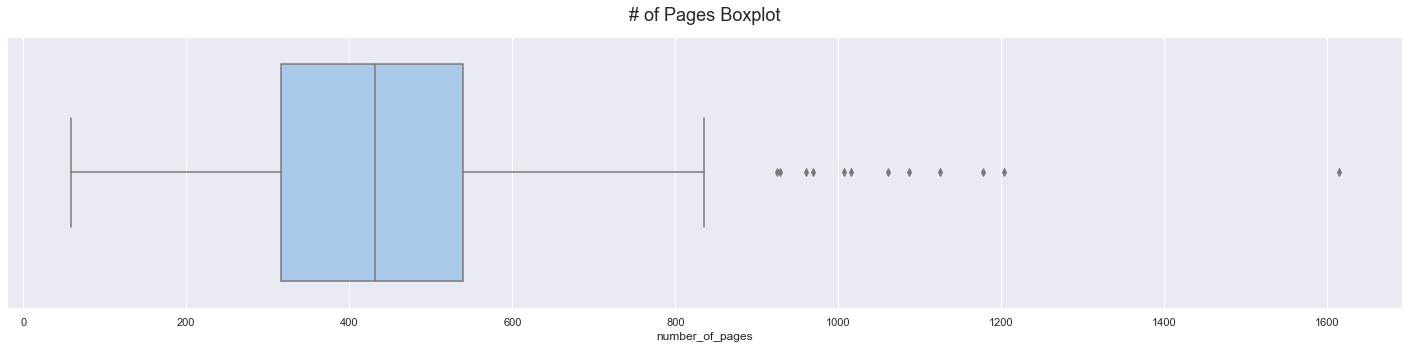


Book with least pages:


,title,author,number_of_pages
76,Here Is New York,E.B. White,58



Book with most pages:


,title,author,number_of_pages
9,The Rise and Fall of the Third Reich: A History of Nazi Germany,William L. Shirer,1614


In [120]:
## Turn off future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(df['number_of_pages'])
ax.set_title('# of Pages Boxplot', fontdict={'fontsize':18}, pad=16)
plt.show();

## Book with Least & Most Pages
print('\nBook with least pages:')
display(df[df['number_of_pages'] == df['number_of_pages'].min()][['title','author','number_of_pages']])

print('\nBook with most pages:')
display(df[df['number_of_pages'] == df['number_of_pages'].max()][['title','author','number_of_pages']])

#### Year Published

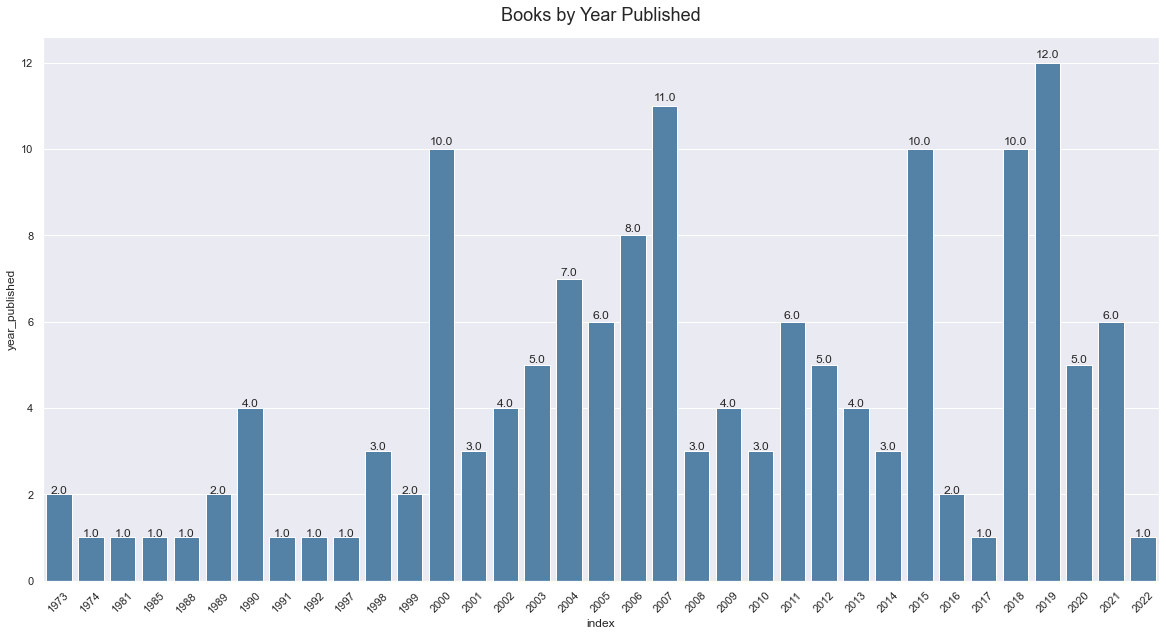

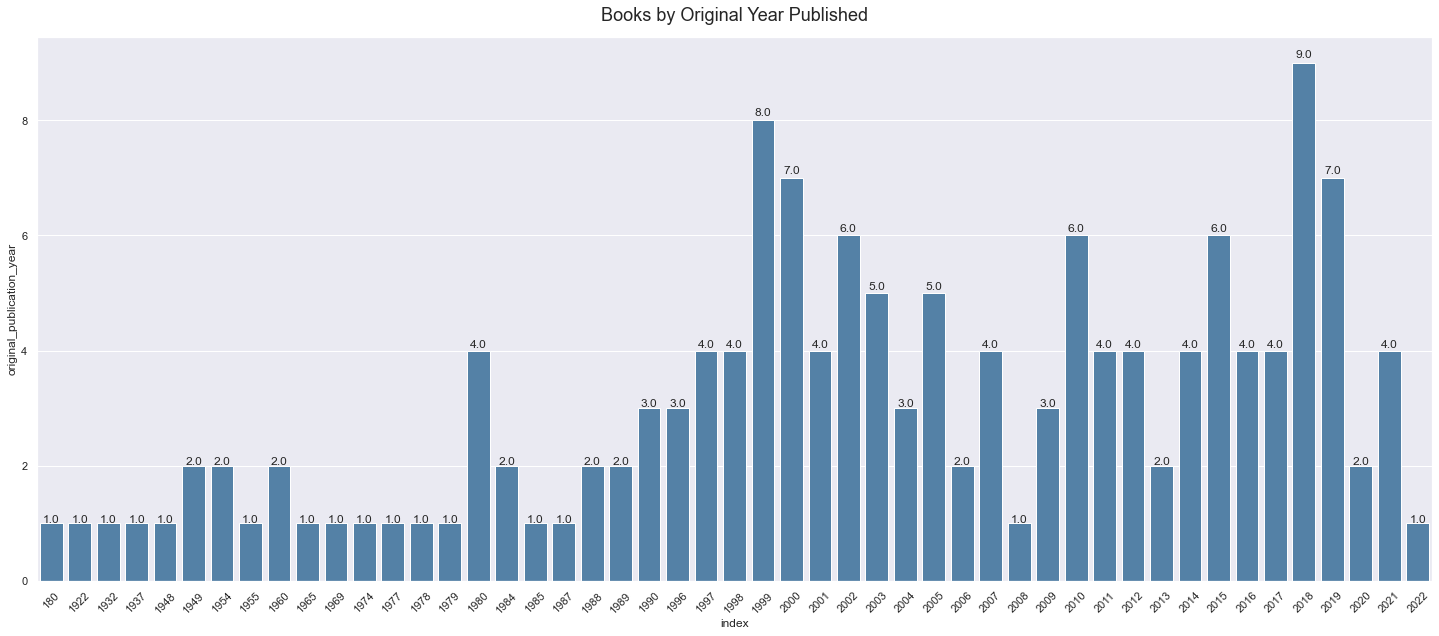

In [121]:
## Year Published
temp = pd.DataFrame(df['year_published'].value_counts().sort_index()).reset_index()
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data = temp, x = 'index',y = 'year_published',orient='v', color = 'steelblue')
ax.set_title('Books by Year Published', fontdict={'fontsize':18}, pad=16)
show_values(ax, "v", space=0.25)

for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.show();


## Original Year Published
temp = pd.DataFrame(df['original_publication_year'].value_counts().sort_index()).reset_index()
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(data = temp, x = 'index',y = 'original_publication_year',orient='v', color = 'steelblue')
ax.set_title('Books by Original Year Published', fontdict={'fontsize':18}, pad=16)
show_values(ax, "v", space=0.25)

for item in ax.get_xticklabels():
    item.set_rotation(45)
    
plt.show();

#### Binding

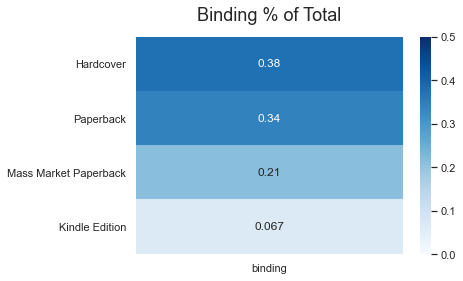

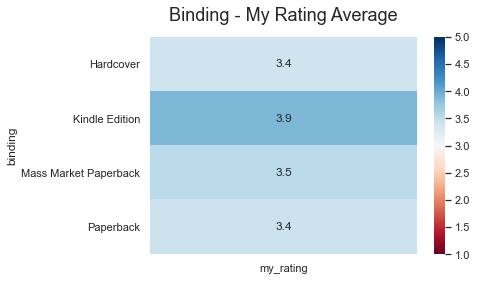

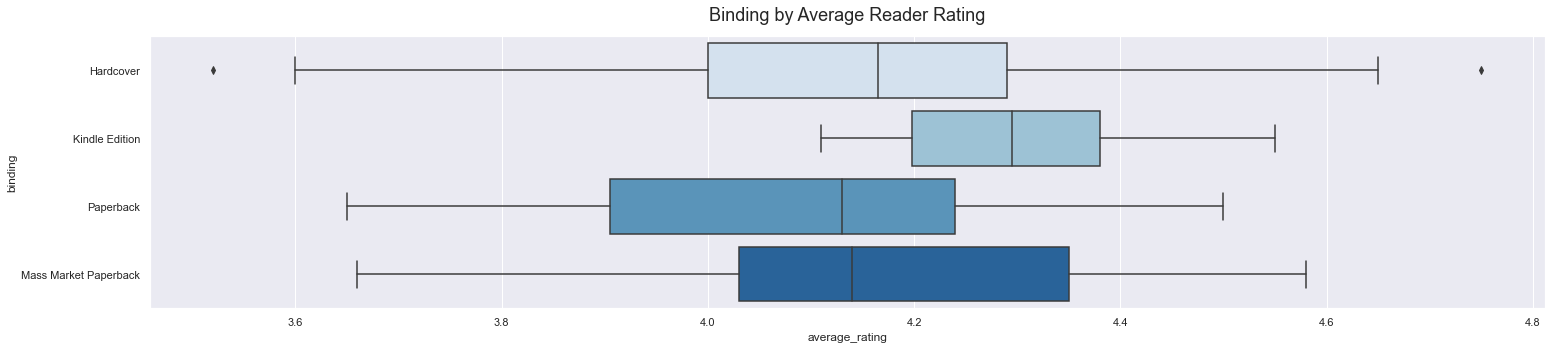

In [179]:
## Binding % of Total
temp = pd.DataFrame(df['binding'].value_counts(normalize = True, dropna = False))
heatmap = sns.heatmap(temp, vmin = 0, vmax = 0.5, annot=True, cmap="Blues")
heatmap.set_title('Binding % of Total', fontdict={'fontsize':18}, pad=16)
plt.show();

## Binding by My Rating Heatmap
temp = df[['my_rating','binding']].groupby('binding').mean()
heatmap = sns.heatmap(temp, vmin = 1, vmax = 5, annot=True, cmap="RdBu")
heatmap.set_title('Binding - My Rating Average', fontdict={'fontsize':18}, pad=16)
plt.show();

## Binding by Average Rating
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(data = df, x = 'average_rating', y ='binding', palette = 'Blues')
ax.set_title('Binding by Average Reader Rating', fontdict={'fontsize':18}, pad=16)
plt.show()

#### Average Rating - By All Readers

Average reader rating: 4.14


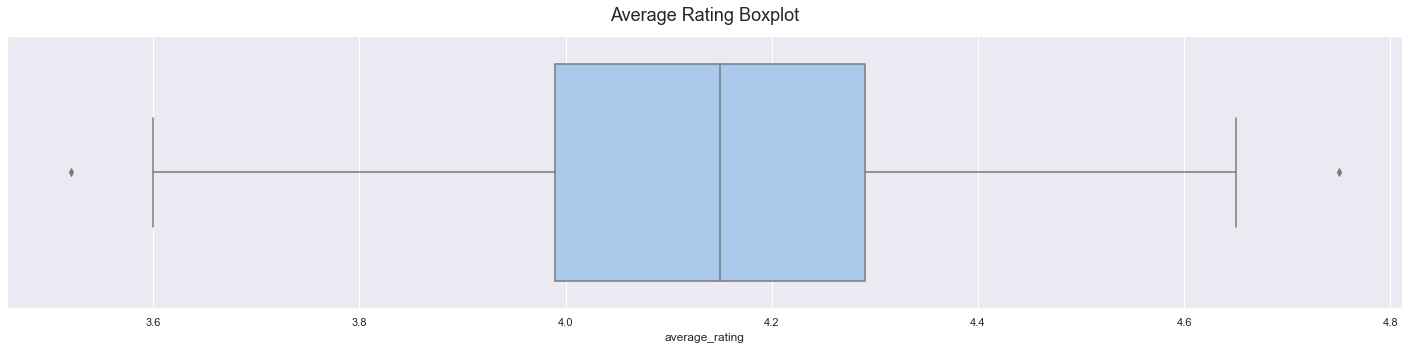

In [122]:
print(f"Average reader rating: {round(df['average_rating'].mean(),2)}")

fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(df['average_rating'])
ax.set_title('Average Rating Boxplot', fontdict={'fontsize':18}, pad=16)
plt.show()

#### My Rating

My average rating: 3.48


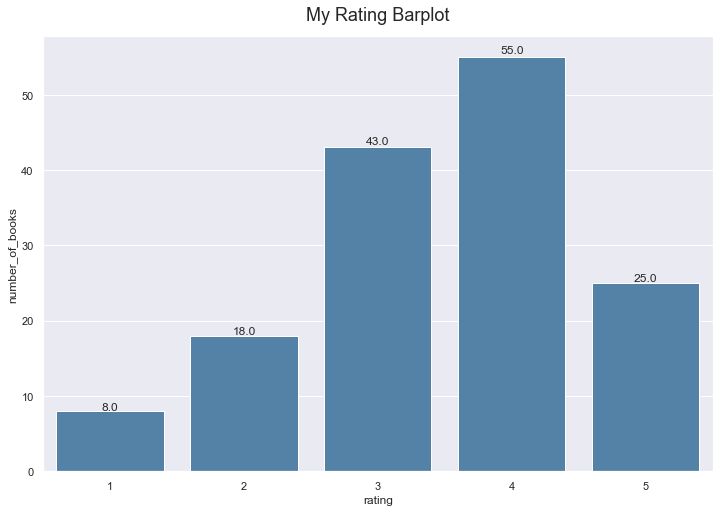

In [123]:
print(f"My average rating: {round(df['my_rating'].mean(),2)}")

temp = df['my_rating'].value_counts().sort_index().reset_index()
temp.columns = ['rating','number_of_books']

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=temp, x ='rating', y = 'number_of_books', color= 'steelblue')
ax.set_title('My Rating Barplot', fontdict={'fontsize':18}, pad=16)
show_values(ax)
plt.show()


#### My Rating vs Average Rating

Overall avg. difference: -0.67


Highest negative rating difference: -3.1900000000000004


,title,my_rating,average_rating
9,The Rise and Fall of the Third Reich: A History of Nazi Germany,1,4.19




Highest positive rating difference: 1.12


,title,my_rating,average_rating
89,The Monk Who Sold His Ferrari: A Fable About Fulfilling Your Dreams and Reaching Your Destiny,5,3.88


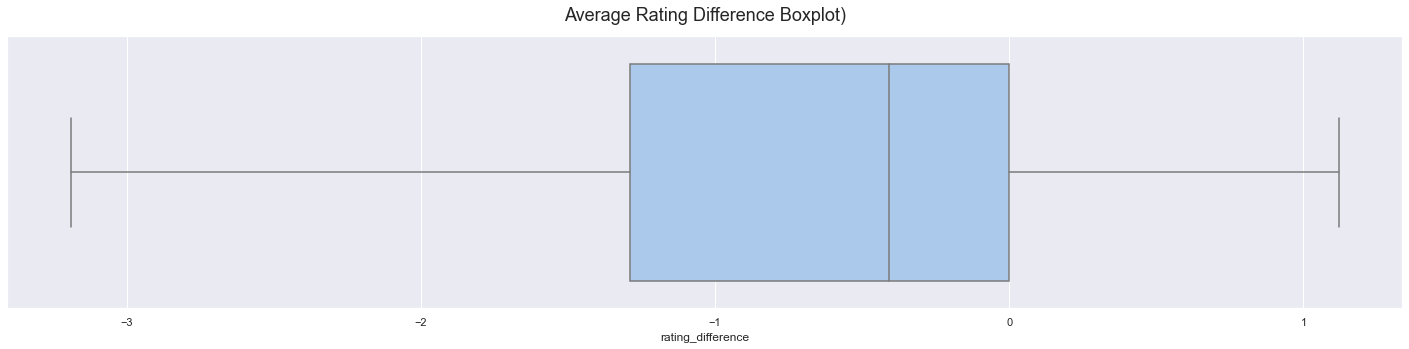

Rating Difference Distribution:


,rating_difference
count,149.000000
mean,-0.666711
std,1.019790
min,-3.190000
25%,-1.290000
50%,-0.410000
75%,0.000000
max,1.120000


In [124]:
print(f"Overall avg. difference: {round(df['my_rating'].mean() - df['average_rating'].mean(),2)}")

temp = df.copy()
temp['rating_difference'] = temp['my_rating'] - temp['average_rating']

print(f"\n\nHighest negative rating difference: {temp['rating_difference'].min()}")
display(temp[temp['rating_difference'] == temp['rating_difference'].min()][['title','my_rating','average_rating']])
print(f"\n\nHighest positive rating difference: {temp['rating_difference'].max()}")
display(temp[temp['rating_difference'] == temp['rating_difference'].max()][['title','my_rating','average_rating']])


fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(temp['rating_difference'])
ax.set_title('Average Rating Difference Boxplot)', fontdict={'fontsize':18}, pad=16)
plt.show()

print('Rating Difference Distribution:')
display(pd.DataFrame(temp['rating_difference'].describe()))

#### Correlation Examples
https://realpython.com/numpy-scipy-pandas-correlation-python/

###### Correlation Graph (inc. Linear Regression)

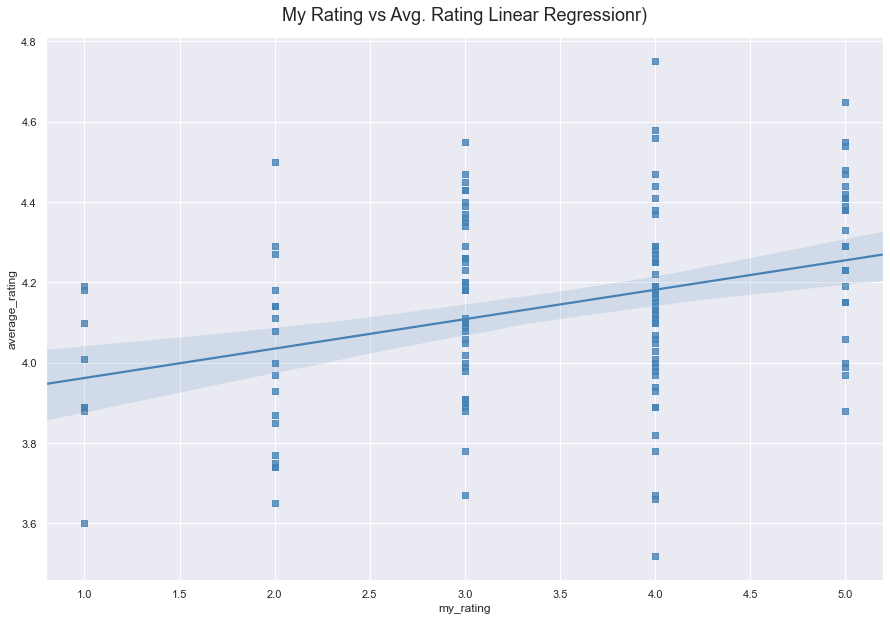

In [125]:
#fig, ax = plt.subplots(figsize=(15, 10))
#sns.scatterplot(data = df, x = 'my_rating', y = 'average_rating').set(title = 'My Rating vs Avg. Rating Relationship')
#plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data = df, x = 'my_rating', y = 'average_rating', truncate=False, 
            color = 'steelblue',marker='s')
ax.set_title('My Rating vs Avg. Rating Linear Regressionr)', fontdict={'fontsize':18}, pad=16)
plt.show()

###### Numpy

In [126]:
np_corr = np.corrcoef(df['my_rating'],df['average_rating'])
display(pd.DataFrame(np_corr))
print(f"My vs Avg. Rating Correlations: {round(np_corr[0,1],4)}")

,0,1
0,1.000000,0.342721
1,0.342721,1.000000


My vs Avg. Rating Correlations: 0.3427


###### Scipy

In [127]:
import scipy.stats

x = df['my_rating']
y = df['average_rating']

print(f'Pearson r: {scipy.stats.pearsonr(x, y)}')
print(f'Pearson r Correlation: {scipy.stats.pearsonr(x, y)[0]}')
print(f'Pearson r P Value: {scipy.stats.pearsonr(x, y)[1]}')
## corr, p = scipy.stats.pearsonr(x,y)

print(f'\nSpearman rho: {scipy.stats.spearmanr(x, y)}')
print(f'Spearman rho Correlation: {scipy.stats.spearmanr(x, y).correlation}')
print(f'Spearman rho P Value: {scipy.stats.spearmanr(x, y).pvalue}')

print(f'\nKenadll tau: {scipy.stats.kendalltau(x, y)}')
print(f'Kenadll tau Correlation: {scipy.stats.kendalltau(x, y).correlation}')
print(f'Kenadll tau P Value: {scipy.stats.kendalltau(x, y).pvalue}')

Pearson r: (0.342720876335871, 1.8814297353351062e-05)
Pearson r Correlation: 0.342720876335871
Pearson r P Value: 1.8814297353351062e-05

Spearman rho: SpearmanrResult(correlation=0.3201782407405466, pvalue=6.872221435192531e-05)
Spearman rho Correlation: 0.3201782407405466
Spearman rho P Value: 6.872221435192531e-05

Kenadll tau: KendalltauResult(correlation=0.24483350404613724, pvalue=7.772003239145632e-05)
Kenadll tau Correlation: 0.24483350404613724
Kenadll tau P Value: 7.772003239145632e-05


###### Pandas

In [49]:
x = df['my_rating']
y = df['average_rating']

print(f'Pearson r Correlation: {x.corr(y)}')
print(f'Spearman rho Correlation: {x.corr(y, method="spearman")}')
print(f'Kendall tau Correlation: {x.corr(y, method="kendall")}') 

Pearson r Correlation: 0.3427208763358711
Spearman rho Correlation: 0.3201782407405466
Kendall tau Correlation: 0.24483350404613724


###### Linear Regression w/Scipy

Slope: 0.07321047678795486
Intercept: 3.888704516938519
R Value (Correlation): 0.342720876335871
P Value: 1.8814297353351146e-05
Standard Error: 0.016551669205908275
Regression line: y=3.89+0.07x, r=0.34


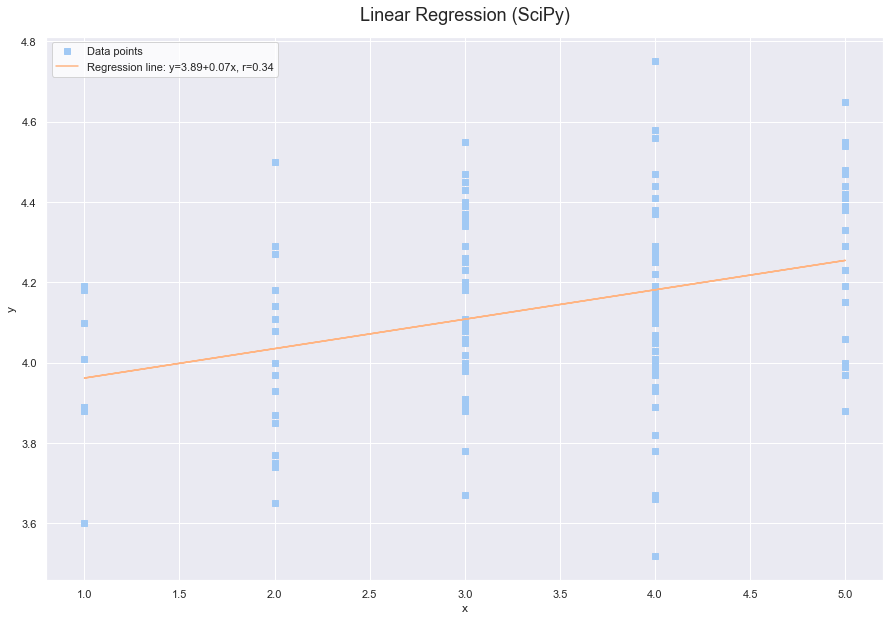

In [128]:
x = df['my_rating']
y = df['average_rating']

result = scipy.stats.linregress(x, y)
print(f'Slope: {result.slope}')
print(f'Intercept: {result.intercept}')
print(f'R Value (Correlation): {result.rvalue}')
print(f'P Value: {result.pvalue}')
print(f'Standard Error: {result.stderr}')

## Capture all values
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
print(line)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
ax.set_title('Linear Regression (SciPy)', fontdict={'fontsize':18}, pad=16)
plt.show()

## Feature Engineering

In [579]:
## Authors - count of books read
temp = pd.DataFrame(df['author'].value_counts())
temp.reset_index(inplace = True)
temp.columns = ['author','author_read_count']
df = df.merge(temp, on = 'author', how = 'left')

## Create additional authors flag
df['additional_authors_flag'] =  (~df['additional_authors'].isna()) * 1

## Create Years Since Published
df['years_since_published'] = int(datetime.date.today().strftime('%Y')) - df['year_published']
df['years_since_org_published'] = int(datetime.date.today().strftime('%Y')) - df['original_publication_year']

#### Analysis of New Features - Publication Years

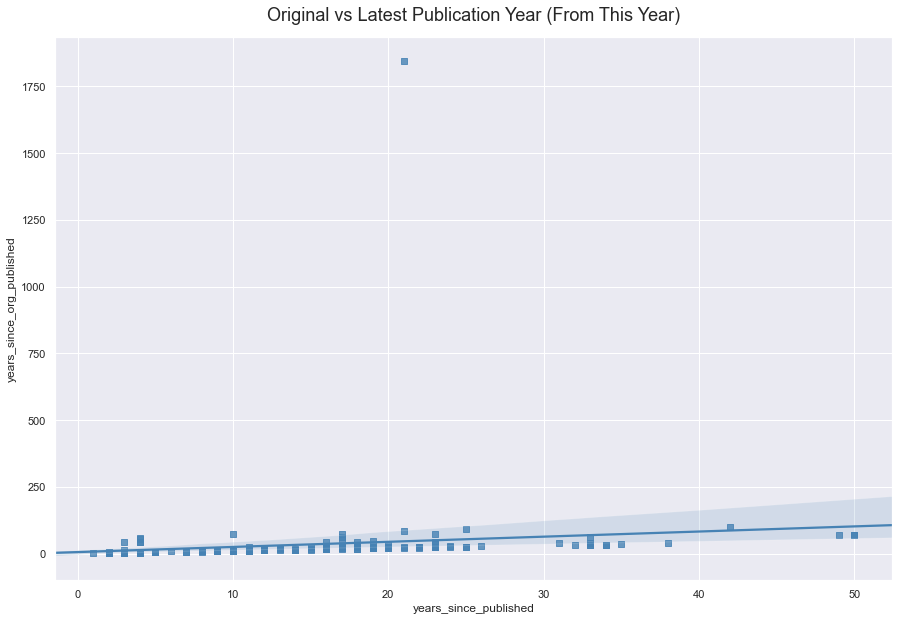

Original vs Latest Publication Year Correlations: 0.1292


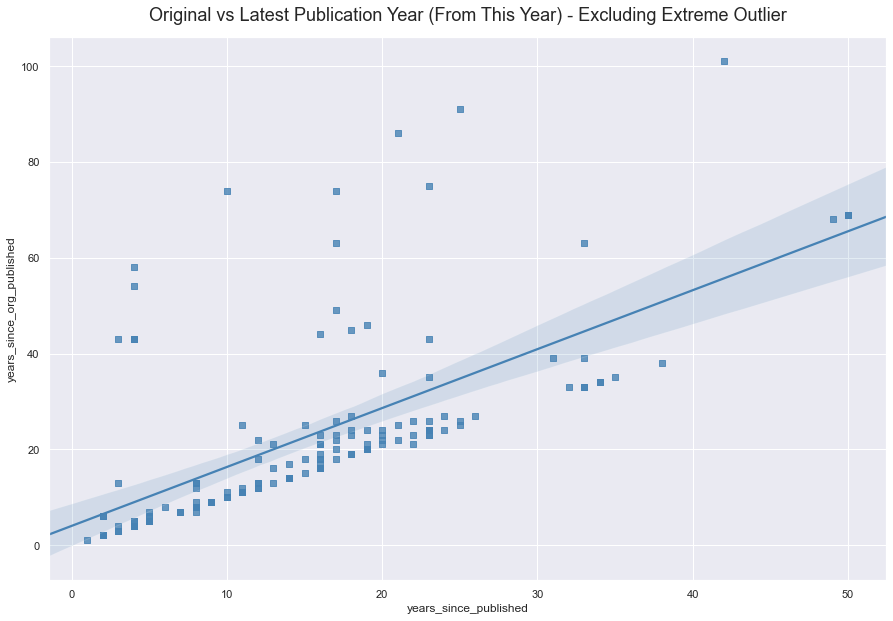

Original vs Latest Publication Year Correlations: 0.6418


In [52]:
## Original vs Latest Publication Year
fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data = df, x = 'years_since_published', y = 'years_since_org_published', truncate=False, 
            color = 'steelblue',marker='s')
ax.set_title('Original vs Latest Publication Year (From This Year)', fontdict={'fontsize':18}, pad=16)
plt.show()

np_corr = np.corrcoef(df['years_since_published'],df['years_since_org_published'])
print(f"Original vs Latest Publication Year Correlations: {round(np_corr[0,1],4)}")

## Original vs Latest Publication Year - Excluding Extreme Outlier
temp = df[df['years_since_org_published'] < 1000].copy()

fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data = temp, x = 'years_since_published', y = 'years_since_org_published', truncate=False, 
            color = 'steelblue',marker='s')
ax.set_title('Original vs Latest Publication Year (From This Year) - Excluding Extreme Outlier', fontdict={'fontsize':18}, pad=16)
plt.show()

np_corr = np.corrcoef(temp['years_since_published'],temp['years_since_org_published'])
print(f"Original vs Latest Publication Year Correlations: {round(np_corr[0,1],4)}")

## Pair Plots

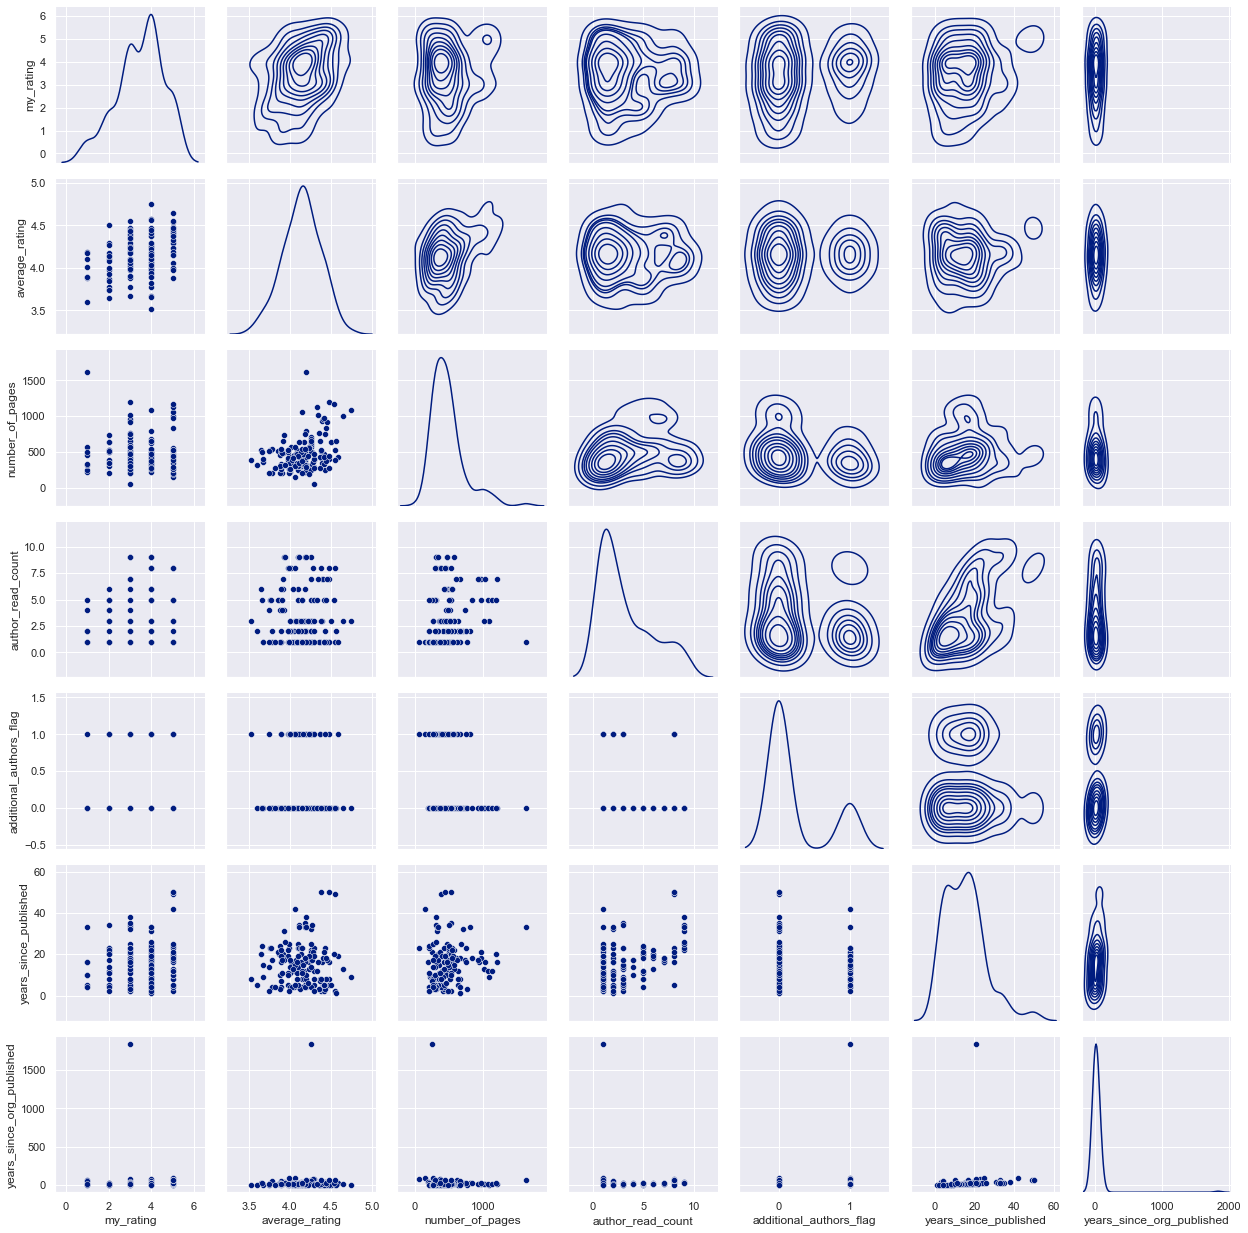

In [182]:
## Define Numeric Columns 
temp = df[['my_rating','average_rating','number_of_pages','author_read_count','additional_authors_flag','years_since_published','years_since_org_published']]

## Pair Grid with Scatterplots & Kde Plot
sns.set_palette('dark') ## Pastel palette is a bit light foir this graph type
g = sns.PairGrid(temp, diag_sharey=False)
g.map_upper(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
plt.show();

## Correlation Analysis

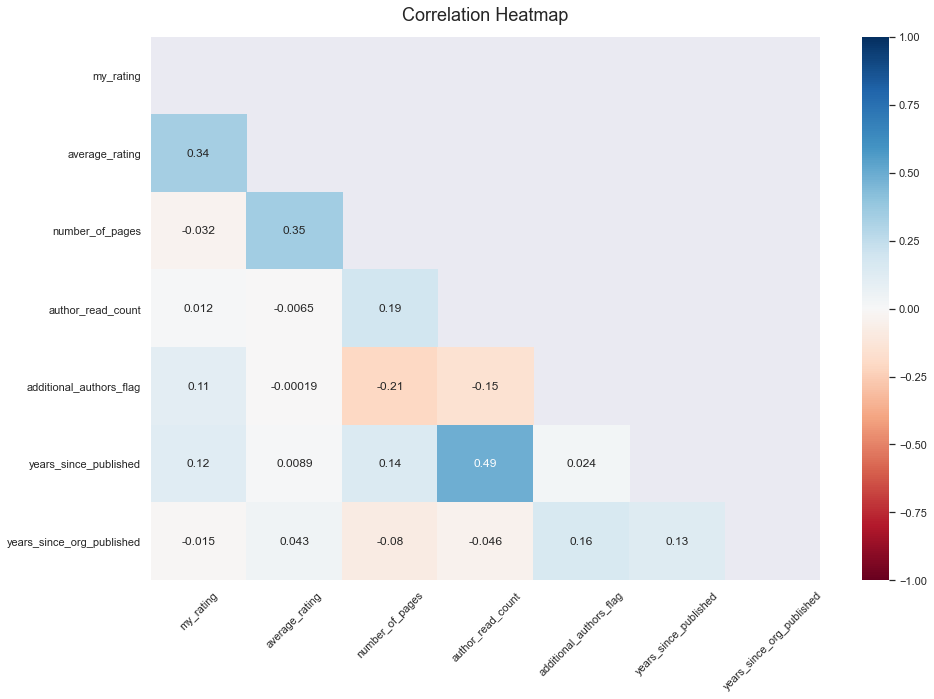

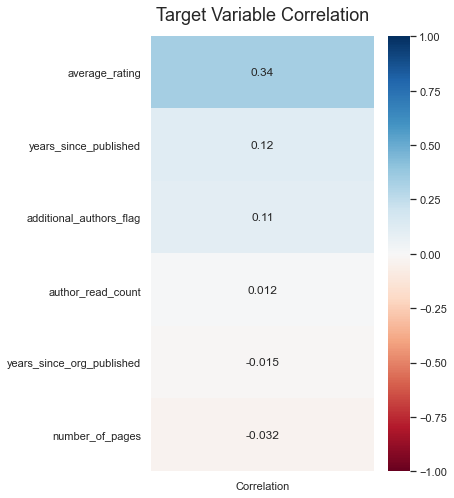

In [183]:
## Define Numeric Columns 
temp = df[['my_rating','average_rating','number_of_pages','author_read_count','additional_authors_flag','years_since_published','years_since_org_published']]

## Plot correlation
fig, ax = plt.subplots(figsize=(15, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(temp.corr(), dtype=np.bool))
heatmap = sns.heatmap(temp.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

## Rotate axis Labels
for item in heatmap.get_xticklabels():
    item.set_rotation(45)
    
## Create correlation to target variable (only) heatmap
target_var = 'my_rating'
temp_1 = temp.drop(target_var, axis=1).apply(lambda x: x.corr(temp[target_var]))
#### Sort by highest correlation
temp_1.sort_values(inplace = True, ascending = False)

#### Plot correlation in heatmap
fig, ax = plt.subplots(figsize=(5, 8))
heatmap = sns.heatmap(pd.DataFrame(temp_1), vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Target Variable Correlation', fontdict={'fontsize':18}, pad=16)
heatmap.set_xticklabels(['Correlation'])
plt.show();

## Model Development

In [610]:
## Keep all numeric columns & binding (categorical)
#read_df = df.copy()
df = read_df.copy()
df = df[['my_rating','average_rating','number_of_pages','author_read_count','additional_authors_flag','years_since_published','years_since_org_published',
         'binding']]

## Variable Setup
target_variable = 'my_rating'
test_size=0.3
random_state = 42

#### Data Cleanup - Missing Values

In [254]:
## Completed above

#### Data Clean Up - Outliers

In [611]:
## Cap years_since_org_published to 100 years
df['years_since_org_published'].clip(upper = 100, inplace =True)

#### Calculate new correlation to target variable
np_corr = np.corrcoef(df['my_rating'],df['years_since_org_published'])
print(f"New Correlation: {round(np_corr[0,1],4)}")

New Correlation: 0.1427


Note: Clearly outliers were impacting correlation to target variable

#### Encoding Categoricals
Note: Have kept all variables - will rerun to see if I have fallen into dummy variable trap

In [612]:
## Simple dummy/OneHot encoding
cols = ['binding']
df = pd.get_dummies(df, columns=cols,
                    drop_first = False)

#### Data Normalisation / Standardisation

In [591]:
## Normalisation
from sklearn.preprocessing import MinMaxScaler
#### Craete min - max scaler object
scaler = MinMaxScaler()
#### Normalize the data to the same scall (0-1) - does not affect data shape
temp = df.drop(target_variable, axis = 1)
temp=pd.DataFrame(scaler.fit_transform(temp),
                  columns=temp.columns, index=temp.index)
df = df[[target_variable]].join(temp)

Note: Normalisation makes performance worse (Loss of granularity)

#### Train Test Split


In [613]:
## Convert data to numpy arrays
y = df[target_variable].values 
X_cols = df.drop(target_variable, axis = 1).columns
X = df.drop(target_variable, axis = 1).values

## Split dataset into train and test sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
## Details of split
print(f'Original Dataset: {len(df)} Records')
print(f'Training Set: {len(X_train)} Records ({1-test_size})')
print(f'Test Set: {len(X_test)} Records ({test_size})')
print(f'\nNumber of Training Features: {X_train.shape[1]}')

Original Dataset: 149 Records
Training Set: 104 Records (0.7)
Test Set: 45 Records (0.3)

Number of Training Features: 10


#### Model Build - "Dumb Models"

In [614]:
target_mode = df[target_variable].mode()[0]
target_mean = round(df[target_variable].mean())

for i in [target_mode, target_mean]:
    pred = [i] * len(y_test) 
    ## Create correct flag
    correct = pred == y_test
    print(f"Accuracy: {round(correct.sum() / len(y_test),4)}")

Accuracy: 0.3111
Accuracy: 0.3111


Note: At the very least our model needs to do better than 31.1% accuracy

#### Logistic Regression (Multi-Class)

In [615]:
from sklearn.linear_model import LogisticRegression
## Create Logistic Regression object
log_reg = LogisticRegression(fit_intercept=False, penalty='l2', solver = 'lbfgs')                                  
## Fit to training dataset
log_reg.fit(X_train, y_train)  

## Create coefficient matrix
coef_df = pd.DataFrame(log_reg.coef_, columns = X_cols, index=log_reg.classes_).T
display(coef_df)

classification_model_eval(log_reg, X_test, y_test)

/Users/nw/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,1,2,3,4,5
average_rating,-0.103334,-0.031160,0.026553,0.210307,-0.102366
number_of_pages,0.001508,-0.001253,0.000241,-0.000803,0.000308
author_read_count,-0.087511,0.068982,0.098181,0.016214,-0.095866
additional_authors_flag,-0.014316,-0.006468,-0.018199,0.054621,-0.015638
years_since_published,-0.129646,0.093556,-0.011839,-0.000270,0.048199
years_since_org_published,0.043106,-0.089593,0.015657,0.021607,0.009222
binding_Hardcover,-0.016913,0.003376,-0.014524,0.069601,-0.041540
binding_Kindle Edition,-0.007722,-0.006944,0.007260,-0.004025,0.011431
binding_Mass Market Paperback,0.011020,-0.006415,0.017436,-0.033054,0.011013
binding_Paperback,-0.007375,0.006212,-0.004113,0.019667,-0.014390



 Accuracy: 0.4


,prediction
4,0.844444
3,0.133333
5,0.022222


## Other Models

#### Linear Regression

###### Model Build - Linear Regression


In [487]:
from sklearn.linear_model import LinearRegression
## Create Linear Regression object
linearregression = LinearRegression()                                    
## Fit to training dataset
linearregression.fit(X_train, y_train)  

print("Intercept of the linear equation:", linearregression.intercept_) 
#print("\nCoefficients of the equation are:", linearregression.coef_)
## Create coefficient matrix
coef_df = pd.DataFrame(linearregression.coef_, index = X_cols, columns = ['coefficient'])
display(coef_df.sort_values('coefficient', ascending = False))

Intercept of the linear equation: -5.927029979619592


,coefficient
average_rating,2.321740
additional_authors_flag,0.172322
binding_Kindle Edition,0.126790
years_since_published,0.024179
binding_Paperback,0.014705
years_since_org_published,0.000080
number_of_pages,-0.000984
author_read_count,-0.021765
binding_Hardcover,-0.068364
binding_Mass Market Paperback,-0.073130


###### Model Evaluation - Linear Regression

In [500]:
## Create Predictions
pred = linearregression.predict(X_test)
#### As the target variable is a discrete value we will round to nearest whole number
pred = pred.round().astype(int)

## Create correct flag
correct = pred == y_test
## Create dataframe with expected and predicted results 
eval_df = pd.DataFrame({'y_test':y_test,'prediction':pred, 'correct':correct})
print(f"Linear Regression Accuracy: {round(eval_df['correct'].sum() / len(eval_df),4)}")

## Display predicted value %
display(pd.DataFrame(eval_df['prediction'].value_counts(normalize = True)))

Linear Regression Accuracy: 0.3556


,prediction
3,0.533333
4,0.333333
5,0.088889
2,0.044444


#### Decision Tree

In [502]:
from sklearn.tree import DecisionTreeClassifier
## Create Linear Regression object
dt = DecisionTreeClassifier(criterion = 'gini')                                  
## Fit to training dataset
dt.fit(X_train, y_train)  

classification_model_eval(dt, X_test, y_test)


Accuracy: 0.3111


,prediction
4,0.400000
3,0.266667
5,0.155556
2,0.133333
1,0.044444


#### Random Forest

In [503]:
from sklearn.ensemble import RandomForestClassifier
## Create Linear Regression object
rf = RandomForestClassifier()                                  
## Fit to training dataset
rf.fit(X_train, y_train)  

classification_model_eval(rf, X_test, y_test)


Accuracy: 0.4


,prediction
4,0.444444
3,0.244444
5,0.222222
2,0.044444
1,0.044444


#### Gradient Boosting

###### Model Build - Gradient Boosting

In [504]:
from sklearn.ensemble import GradientBoostingClassifier
## Create Linear Regression object
gb = GradientBoostingClassifier()                                  
## Fit to training dataset
gb.fit(X_train, y_train)  

classification_model_eval(gb, X_test, y_test)


Accuracy: 0.4


,prediction
4,0.422222
3,0.288889
5,0.200000
2,0.044444
1,0.044444


## Multi Model Build - Classification Models

In [518]:
for i in [LogisticRegression(fit_intercept = False), DecisionTreeClassifier(random_state = 42), 
          RandomForestClassifier(random_state = 42), GradientBoostingClassifier(random_state = 42)]:
    model_obj = i                                  
    ## Fit to training dataset
    model_obj.fit(X_train, y_train)
    
    ## Performance
    classification_model_eval(model_obj, X_test, y_test, i)


LogisticRegression(fit_intercept=False) Accuracy: 0.4


/Users/nw/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,prediction
4,0.844444
3,0.133333
5,0.022222



DecisionTreeClassifier(random_state=42) Accuracy: 0.4


,prediction
4,0.333333
3,0.333333
5,0.177778
2,0.088889
1,0.066667



RandomForestClassifier(random_state=42) Accuracy: 0.4222


,prediction
4,0.533333
3,0.222222
5,0.200000
2,0.044444



GradientBoostingClassifier(random_state=42) Accuracy: 0.4222


,prediction
4,0.377778
3,0.333333
5,0.200000
2,0.044444
1,0.044444
